<a href="https://colab.research.google.com/github/sharwinbobde/siamese-nn-oneshot-reproduction/blob/feature-maps/notebooks/experiments/activation_maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

from torch.utils import data
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


## Definition of the dataset class that will hold our examples

In [0]:
class SiameseDataset(data.Dataset):
    """Dataset that reads the data from an npy file and 
    returns a pair to the loader"""
    def __init__(self, data_path=None, labels_path=None, 
                 transform=None, dataset: data.Dataset =None, 
                 data : np.ndarray = None, labels: np.ndarray = None,
                 mean : float = None, std : float = None,
                 transform_data=False):
        self.transform_data = transform_data

        # If we're given another dataset, just take that
        if dataset is not None:
            self.data = dataset.data
            self.labels = dataset.labels
            self.transforms = dataset.transforms

        # We can also pass the data and labels as an array
        elif data is not None:
            self.data = data
            self.labels = labels

            self.mean = mean
            self.std = std 

            
            self.normalize = transforms.Normalize(mean=(self.mean,),
                                                std = (self.std,))
            self.transforms = transforms.Compose([
                transforms.ToTensor(),
                self.normalize
            ])

        # If not, that means that we load it from a file
        else:
            # Load the data and labels
            self.data = np.load(data_path)
            self.labels = np.load(labels_path)

            # for training set, calculate mean and std
            # to normalize
            if mean == None and std == None:
                # stats of the dataset
                self.mean = np.mean(self.data[:,:,:])
                self.std = np.std(self.data[:,:,:])
            # for test set, use mean and std from
            # the train set to normalize
            else:
                self.mean = mean
                self.std = std
            # Normalize by default!
            self.normalize = transforms.Normalize(mean=(self.mean,),
                                                std = (self.std,))
            # We apply the transformations that are given, so we can 
            # join the datasets

            if transform is not None:
              # If we're given transforms it means
              # that we're trying to apply the affine transformations
              self.transforms = transforms.Compose([
                  transform
              ])
            else:
              # If we're not given transforms just return the
              # normalized tensor
              print("Using the default transformations")
              self.transforms = transforms.Compose([
                    transforms.ToTensor(),
                    self.normalize                                
              ])
              
    def __len__(self):
        return len(self.data)
    
    def get_images(self, index):
        _x1 = self.data[index,0,:,:]
        _x2 = self.data[index,1,:,:]
        label = self.labels[index]
        return Image.fromarray(_x1), Image.fromarray(_x2), label
        
    
    def __getitem__(self, index):
        """ Gets the next pair from 
        the dataset and its corresponding label
        (0 or 1 depending on if they're the same
        or a different letter)"""
        _x1 = self.data[index,0,:,:]
        _x2 = self.data[index,1,:,:]
        label = self.labels[index]
        
        # Convert to PIL Images so 
        # we can transform them with affine transforms
        # Just needed to generate the dataset
        if self.transform_data:
            _x1 = Image.fromarray(_x1)
            _x2 = Image.fromarray(_x2)
            
            # we need to convert the x's to images to apply the transforms
            return np.array(self.transforms(_x1)), np.array(self.transforms(_x2)), label
        else:
          # We're trying to train the dataset, so give
          # the data in float32 version that's better for training
          # and apply the ToTensor and normalization transformations
            _x1 = _x1.astype(np.float32)
            _x2 = _x2.astype(np.float32)
            label = label.astype(np.float32)
            return self.transforms(_x1), self.transforms(_x2), label
    
# Some easy functions to visualize the data 
def show_pair(x1, x2, lab):
    """Function to show two images of the dataset side by side"""
    # x1 = x1.numpy()
    # x2 = x2.numpy()
    f ,(ax1, ax2) = plt.subplots(1, 2, sharey= True)
    ax1.imshow(x1.squeeze())
    ax2.imshow(x2.squeeze())
    plt.show()
    print('same' if lab == 1 else 'different')
    
def show_image_pair(i1, i2, lab):
    f ,(ax1, ax2) = plt.subplots(1, 2, sharey= True)
    ax1.imshow(i1)
    ax2.imshow(i2)
    plt.show()
    print('same' if lab == 1 else 'different')
    

### Set up the folder in Google Drive and define the data path

In [3]:
import os
from google.colab import drive
drive.mount('/content/drive/')
!ls "/content/drive/My Drive/Deep Learning Q3"

# Change the current directory to the path so it's more comfortable to work
path = "/content/drive/My Drive/Deep Learning Q3"
os.chdir(path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/
 activation_maps  'Choose a Paper.gdoc'   datasets   saved_models   Seminar


In [4]:
# validation data
valid_data_path = "datasets/validationX.npy"
valid_labels_path = "datasets/validationY.npy"
valid_d = SiameseDataset(valid_data_path, valid_labels_path)
print("Loaded validation set with shape ",valid_d.data.shape)

Using the default transformations
Loaded validation set with shape  (10000, 2, 105, 105)


-------------------------------------
## Definition of the network architecture

In [0]:
class ConvNet(nn.Module):
  """ Convolutional NN used in pair inside the siamese Network """
  def __init__(self):
    super(ConvNet, self).__init__()
    self.conv1 = nn.Conv2d(1, 64, 10)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(64, 128, 7)
    self.conv3 = nn.Conv2d(128,128,4)
    self.conv4 = nn.Conv2d(128,256, 4)
    self.fc1 = nn.Linear(256*6*6, 4096)
  
  def forward(self, x):
    out = self.pool(F.relu(self.conv1(x)))
    out = self.pool(F.relu(self.conv2(out)))
    out = self.pool(F.relu(self.conv3(out)))
    out = F.relu(self.conv4(out))
    out = out.view(-1, 256*6*6)
    # We get the h feature vectors
    out = torch.sigmoid(self.fc1(out))
    return out

class SiameseNet(nn.Module):
  """Siamese Net combining two ConvNets"""
  def __init__(self, net):
    # Receives a net as a parameter, we can just have 1 net 
    # but do the forward pass twice! and then just update once, much more 
    # elegant
    super(SiameseNet, self).__init__()
    # Instantiate two of the same class
    self.convnet = net
    # Final layer and output
    self.prediction_layer = nn.Linear(4096,1)

  def forward(self,x1, x2):
    """Computes the forward given two images"""
    h1 = self.convnet(x1)
    h2 = self.convnet(x2)
    h = self.calculate_l1_distance(h1, h2)
    out = self.prediction_layer(h)
    return out
  
  def calculate_l1_distance(self, h1, h2):
    """Calculates l1 distance between the two given vectors"""
    return torch.abs(h1-h2)

torch.manual_seed(12)

# How to initialize the weights according to the paper
def weights_init(model):
  np.random.seed(12)
  if isinstance(model, nn.Conv2d):
    nn.init.normal_(model.weight, mean = 0.0, std = 1e-2)
    nn.init.normal_(model.bias, mean=0.5, std = 1e-2)
  elif isinstance(model, nn.Linear):
    nn.init.normal_(model.weight, mean= 0.0, std = 0.2)
    nn.init.normal_(model.bias, mean=0.5, std = 1e-2)



### Create the Siamese Network and Initialize weights according to specifications
- Conv layers: 
  - Weights: Normal(0, 1e-2)
  - Bias: Normal(0.5, 1e-2)
- Linear layers: 
  - Weights: Normal(0, 0.2)
  - Bias: Normal(0.5, 1e-2)

In [6]:
conv = ConvNet()
siamese = SiameseNet(conv)
siamese.apply(weights_init)

# Send the network to the GPU if available
#device = torch.device("cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
siamese.to(device)

SiameseNet(
  (convnet): ConvNet(
    (conv1): Conv2d(1, 64, kernel_size=(10, 10), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
    (conv3): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
    (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
    (fc1): Linear(in_features=9216, out_features=4096, bias=True)
  )
  (prediction_layer): Linear(in_features=4096, out_features=1, bias=True)
)

In [0]:
model_save_path = os.path.join("saved_models", "best30k 90.960.th")

# Feature Maps

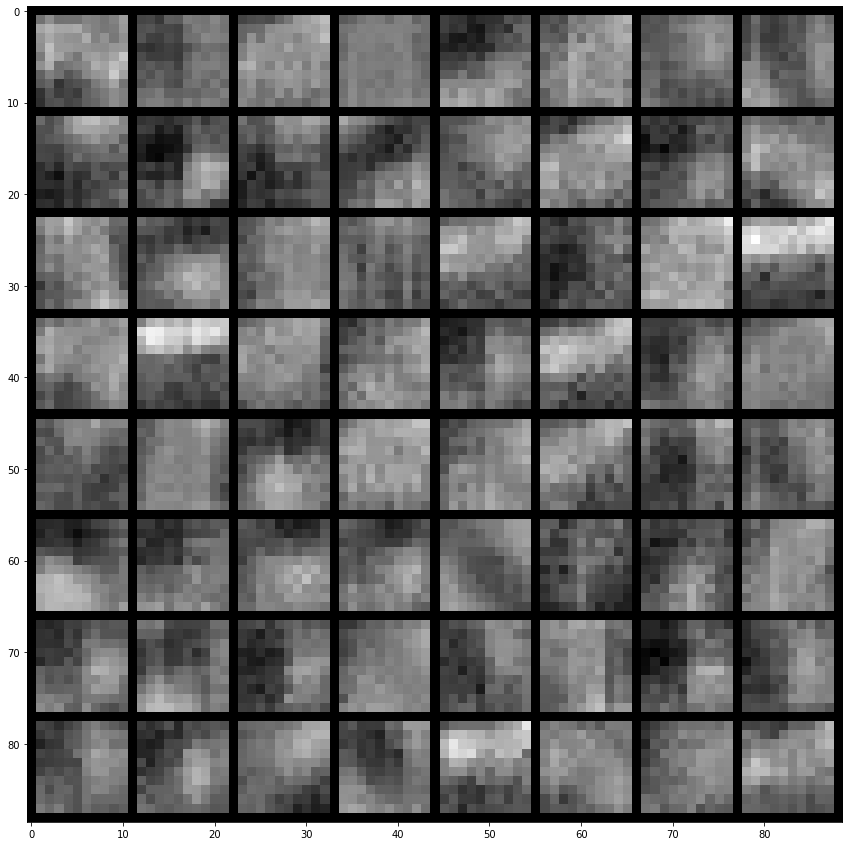

In [10]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# load model from save path
siamese.load_state_dict(torch.load(model_save_path, map_location=device))

# get filter from 1st conv layer
kernels = siamese.convnet.conv1.weight.detach().cpu().clone()

# plot the image in a grid
fig, ax = plt.subplots(figsize=(15, 15))
img = make_grid(kernels, normalize=True, padding=1)

# depth dimension should be the last one while plotting using imshow
ax.imshow(img.permute(1, 2, 0))

# Activation Maps

In [0]:
# forward hook to get the activation
def get_activation(name):
  def hook(model, input, output):
    if activation.get(f"{name}_im1") is None:
      activation[f"{name}_im1"] = output.detach()
    else:
      activation[f"{name}_im2"] = output.detach()
    # print(activation)
  return hook

In [0]:
# initialize siamese network
conv = ConvNet()
siamese = SiameseNet(conv)
siamese.apply(weights_init)

# load saved model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
siamese.to(device)
siamese.load_state_dict(torch.load(model_save_path, map_location=device))

# register hooks to get the activations
siamese.convnet.conv1.register_forward_hook(get_activation('conv1'))
siamese.convnet.conv2.register_forward_hook(get_activation('conv2'))
siamese.convnet.conv3.register_forward_hook(get_activation('conv3'))
siamese.convnet.conv4.register_forward_hook(get_activation('conv4'))

# dictionary to store activations
activation = {}

# create a data loader
test_loader = data.DataLoader(valid_d, shuffle=True, batch_size=1, pin_memory=True, num_workers=4)

# get a sample from the data loader
x1, x2, y = next(iter(test_loader))  
siamese.eval()
x1 = x1.to(device)
x2= x2.to(device)

x1 = x1.view(-1, 1, 105, 105)
x2 = x2.view(-1, 1, 105, 105)

_ = siamese(x1, x2)

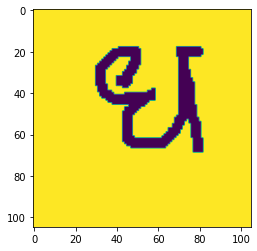

In [14]:
plt.imshow(x1.squeeze().cpu())

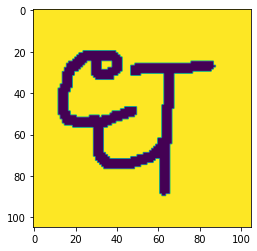

In [15]:
plt.imshow(x2.squeeze().cpu())

In [0]:
def viz_activations(act, ncols, nrows):
  n = act.size(0)
  fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))
  for i in range(nrows):
    for j in range(ncols):
      idx = i*ncols+j
      if idx >= n:
        break
      ax[i, j].imshow(act[idx], cmap="magma")

In [0]:
dims = {"conv1": (8, 8), "conv2": (13, 10), "conv3": (13, 10), "conv4": (16, 16)}

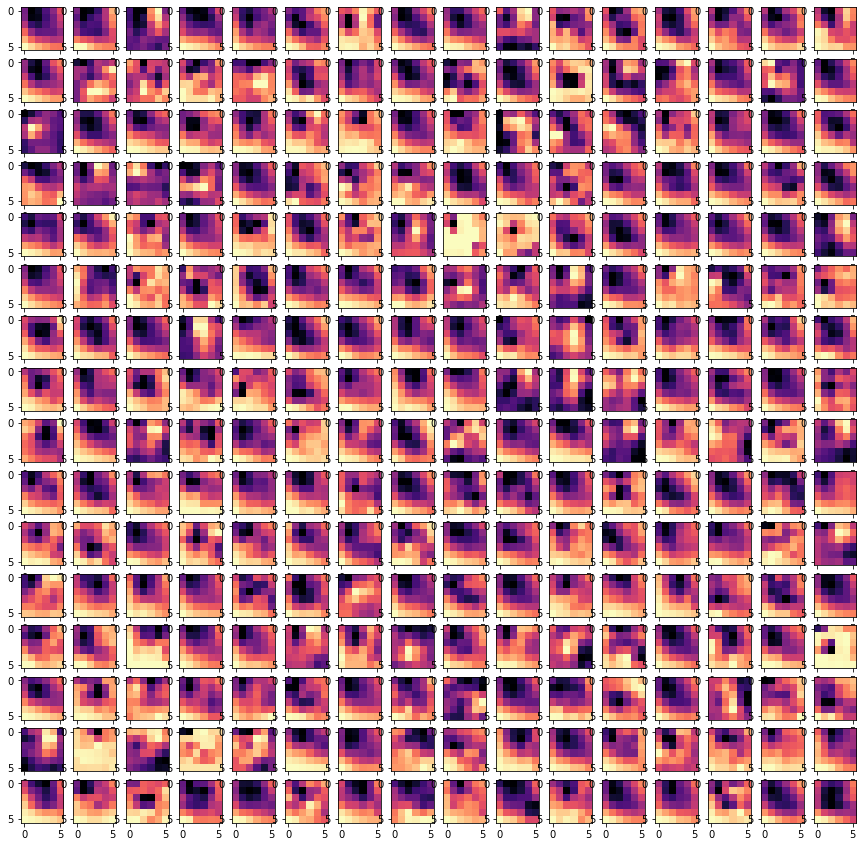

In [18]:
layer = "conv4"
ncols, nrows = dims[layer]
act = activation[f'{layer}_im1'].squeeze().cpu()
viz_activations(act, ncols=ncols, nrows=nrows)

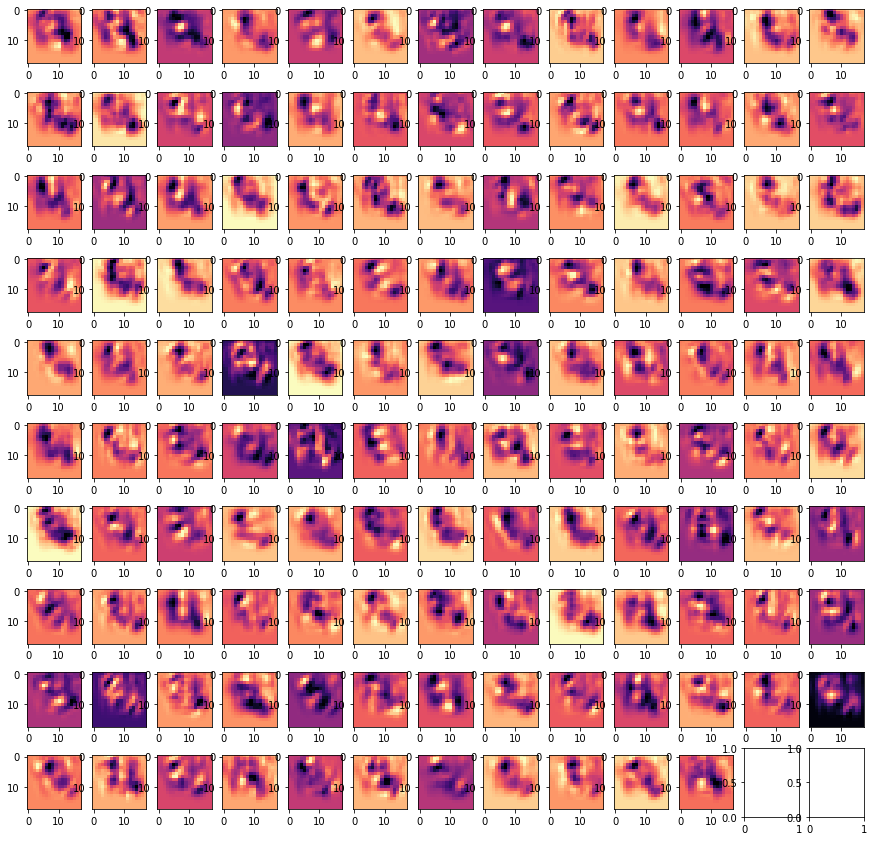

In [19]:
layer = "conv3"
ncols, nrows = dims[layer]
act = activation[f'{layer}_im1'].squeeze().cpu()
viz_activations(act, ncols=ncols, nrows=nrows)

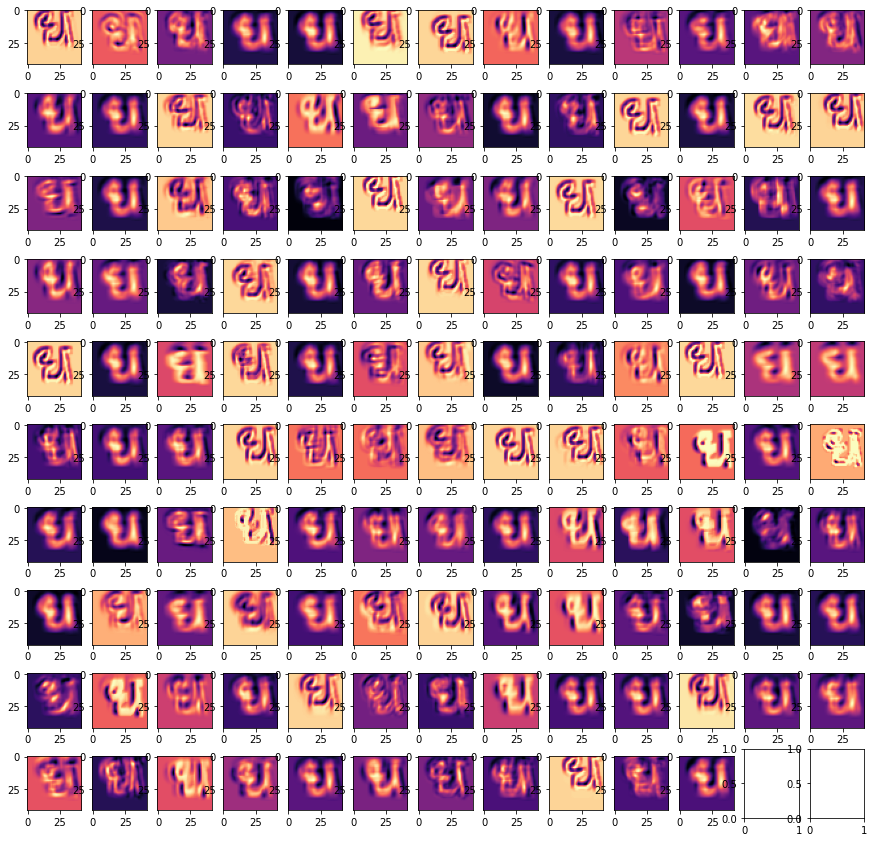

In [20]:
layer = "conv2"
ncols, nrows = dims[layer]
act = activation[f'{layer}_im1'].squeeze().cpu()
viz_activations(act, ncols=ncols, nrows=nrows)

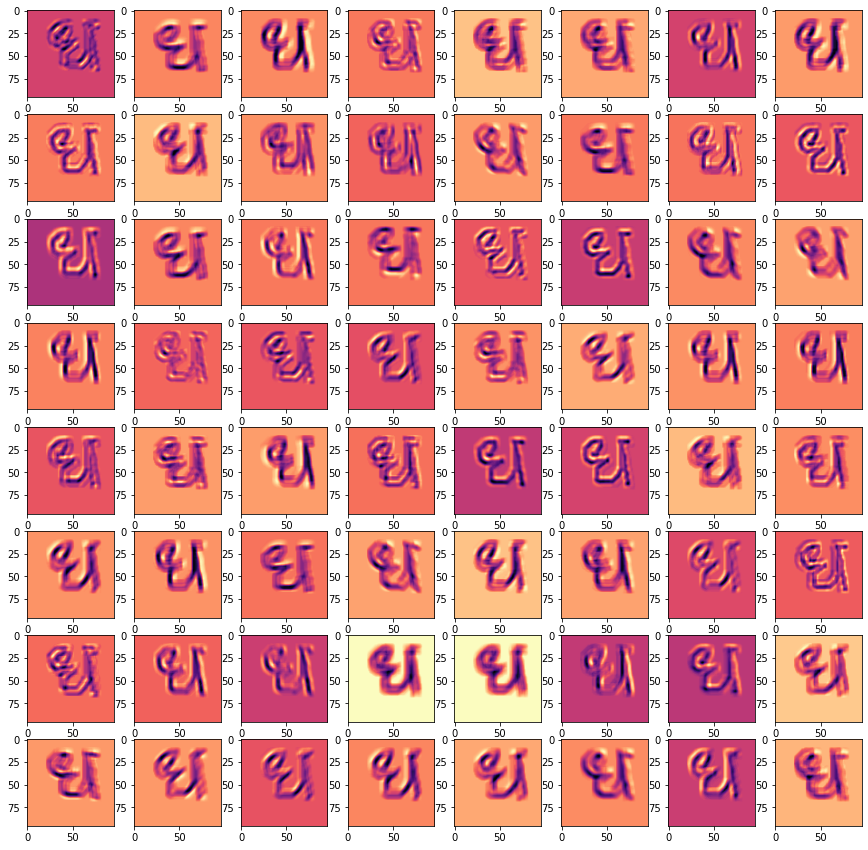

In [21]:
layer = "conv1"
ncols, nrows = dims[layer]
act = activation[f'{layer}_im1'].squeeze().cpu()
viz_activations(act, ncols=ncols, nrows=nrows)